# Kriging, co-kriging

Initial commands

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf') #setting figure format to vector when exported
from matplotlib.ticker import MultipleLocator,MaxNLocator,FormatStrFormatter
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
#pip install scikit-gstat #to be installed for built-in variogram
from skgstat import Variogram
from skgstat.binning import even_width_lags
from scipy.spatial.distance import pdist
from sympy import symbols,simplify
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from sympy import exp

Reading data

In [2]:
dataAll=pd.read_excel('jura_02.xls')
dataAll=dataAll.iloc[1:,[0,1,4,5,6,7,8,9,10]].reset_index(drop=True)
display(dataAll)
data1=dataAll.iloc[:,[0,1,5]] #Here choose the element (element1) for kriging 
display(data1)

x      y     Cd     Cu     Pb     Co     Cr     Ni     Zn
0    2.386  3.077   1.74  25.72  77.36   9.32  38.32  21.32  92.56
1    2.544  1.972  1.335  24.76  77.88     10   40.2  29.72  73.56
2    2.807  3.347   1.61   8.88   30.8   10.6     47   21.4   64.8
3    4.308  1.933   2.15   22.7   56.4  11.92  43.52  29.72     90
4    4.383  1.081  1.565  34.32   66.4  16.32  38.52   26.2   88.4
..     ...    ...    ...    ...    ...    ...    ...    ...    ...
354  4.248  2.489   1.22   5.52   48.8   5.24  27.04  21.04   46.4
355  3.784  3.677   0.64   6.68  34.32  13.92  28.32     18   55.2
356  4.324  2.835   1.65   8.88     60   8.72  33.36  22.72     80
357  3.859  4.022  1.433   43.6   60.8  13.32   47.6  29.12   87.2
358  2.593  3.312  0.325   8.08   26.2   10.6     30     14  54.96

[359 rows x 9 columns]

x      y     Co
0    2.386  3.077   9.32
1    2.544  1.972     10
2    2.807  3.347   10.6
3    4.308  1.933  11.92
4    4.383  1.081  16.32
..     ...    ...    ...
354  4.248  2.489   5.24
355  3.784  3.677  13.92
356  4.324  2.835   8.72
357  3.859  4.022  13.32
358  2.593  3.312   10.6

[359 rows x 3 columns]

Graphical representation of the measurements locations and the values of the selected element at given locations.

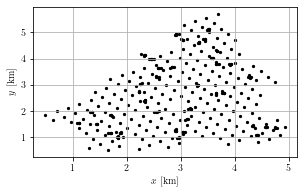

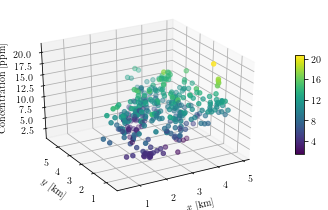

In [3]:
#2D
fig=plt.figure(figsize=(12/2.54,7/2.54))
plt.scatter(data1.iloc[:,0],data1.iloc[:,1],s=5,c='black')
plt.grid()
plt.xlabel('$x$ [km]')
plt.ylabel('$y$ [km]')
plt.show()

#3D
fig=plt.figure(figsize=(12/2.54,7/2.54))
ax=fig.gca(projection='3d')
ax.set_xlabel('$x$ [km]')
ax.set_ylabel('$y$ [km]')
ax.set_zlabel('Concentration [ppm]',rotation=90)
ax.view_init(azim=-120,elev=30)
ax.zaxis.set_rotate_label(False)
points=ax.scatter3D(list(data1.iloc[:,0]),list(data1.iloc[:,1]),list(data1.iloc[:,2]),c=list(data1.iloc[:,2]),cmap='viridis')
fig.colorbar(points, shrink=0.5, aspect=10,format=FormatStrFormatter('%.0f'),ticks=MaxNLocator(5))
plt.tight_layout(pad=0.1)
plt.show()

### Variogram and covariance function

In [4]:
decNr=5 #number of decimals for rouding due to numerical error
hDelta=0.025 #value, which will be used for checking h-hDelta or h+hDelta
hList=np.arange(0.1,2.5+2*hDelta,2*hDelta) 
hList=[round(num, decNr) for num in hList] #rounding, since minor numerical error occurs when generation hList with np.arange

hListRange=[]
for h in hList:
    hListRange.append((round(h-hDelta,decNr),round(h+hDelta,decNr))) #rounding

gamma_hList1=[]
for h in range(len(hList)):    
    pairs1=[]
    for i in range(data1.shape[0]):
        for j in range(i+1,data1.shape[0]):
            if ((data1.iloc[j,0]-data1.iloc[i,0])**2+(data1.iloc[j,1]-data1.iloc[i,1])**2)**0.5>=hListRange[h][0]:
                if ((data1.iloc[j,0]-data1.iloc[i,0])**2+(data1.iloc[j,1]-data1.iloc[i,1])**2)**0.5<=hListRange[h][1]:
                    pairs1.append((data1.iloc[i,2],data1.iloc[j,2]))
                    
    gamma_h=(1/(2*len(pairs1)))*sum([(x - y)**2 for x, y in pairs1])
    #print(hList[h])
    gamma_hList1.append(gamma_h)

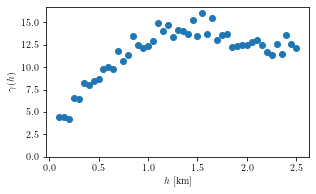

C:\Users\hekic\anaconda3\lib\site-packages\skgstat\Variogram.py:1636: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


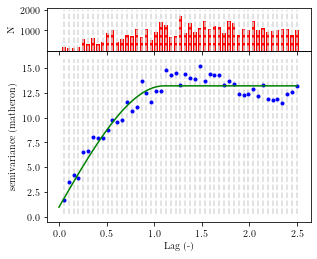

{'name': 'spherical', 'estimator': 'matheron', 'effective_range': 1.1039255903908158, 'sill': 12.20315256680359, 'nugget': 0.9899999999999999}


In [5]:
#Scatter plot of (semi)variogram 
fig=plt.figure(figsize=(12/2.54,7/2.54))
plt.scatter(hList,gamma_hList1)
plt.ylim(bottom=0)
plt.xlabel('$h$ [km]')
plt.ylabel('$\gamma(h)$')
plt.show()

#Built-in semi-variogram
V = Variogram(data1.iloc[:,:2], data1.iloc[:,2],n_lags=len(hListRange),maxlag=hList[-1],use_nugget=True)
V.plot()
fig = plt.gcf()
fig.set_figwidth(12/2.54)
fig.set_figheight(10/2.54)
plt.show()
print(V.describe())

Parameters after optimisation are: [1.77145089e-14 1.34035842e+01 1.15717999e+00]


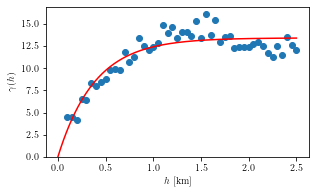

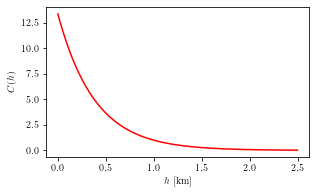

In [6]:
#Determination of empirical variogram function
def func(h, b1, b2, a2):
    return b1+b2*(1-np.exp(-3*h/a2)) #combination of constant and exponent function is used here for variogram approximation (Check Prostorska statistika by prof. Turk)

xdata = np.array(hList)
ydata = np.array(gamma_hList1)

#################### TO BE CHANGED IF THE curve_fit GIVES LINEAR FUNCTION ######################
p0_1=[0.2,5,100] #initial guess 
#################### TO BE CHANGED IF THE curve_fit GIVES LINEAR FUNCTION ######################

popt1, pcov1 = curve_fit(func, xdata, ydata, p0=p0_1,bounds=((0,-np.inf,-np.inf), (np.inf,np.inf,np.inf))) #Use non-linear least squares to fit a function func to data
print('Parameters after optimisation are: {}'.format(popt1))

#Empiciral variogram function is defined as varFunc
def varFunc(h,paramList): #parameters are stored inside paramList
    return paramList[0]+paramList[1]*(1-np.exp(-3*h/paramList[2]))

#Plot of semivariogram with empirical variogram function
fig=plt.figure(figsize=(12/2.54,7/2.54))
plt.scatter(xdata,ydata)
xdata = np.arange(0,hList[-1]+0.01,0.01) #adding first value '0' and shortening the hDelta interval for nicer plot
plt.plot(xdata, varFunc(xdata, paramList=popt1), 'red')
plt.ylim(bottom=0)
plt.xlabel('$h$ [km]')
plt.ylabel('$\gamma(h)$')
plt.show()

#Determiantion of the covariance function
varFuncMax1=max(varFunc(xdata, paramList=popt1))
def covFunc(h,varFuncMax,paramList): #parameters are stored inside paramList
    return varFuncMax -(paramList[0]+paramList[1]*(1-np.exp(-3*h/paramList[2])))

fig=plt.figure(figsize=(12/2.54,7/2.54))
xdata = np.arange(0,hList[-1]+0.01,0.01) #adding first value '0' and shortening the hDelta interval for nicer plot
plt.plot(xdata, covFunc(xdata,varFuncMax=varFuncMax1,paramList=popt1), 'red')
#plt.ylim(bottom=0)
plt.xlabel('$h$ [km]')
plt.ylabel('$C(h)$')
plt.show()

## Ordinary kriging for element 1

In [7]:
#Selecting the coordinates for the point, where kriging will be performed

#################### HERE ENTER THE COORDINATES FOR POINT WHERE KRIGING WILL BE PERFORMED AND NUMBER OF THE NEARBY POINTS ######################
nNearPoints1=100 #10*10 #number of nearby points
coordX=3.3 #x coordX for the point we are performing kriging
coordY=2.8 #y coordY for the point we are performing kriging
#################### HERE ENTER THE COORDINATES FOR POINT WHERE KRIGING WILL BE PERFORMED AND NUMBER OF THE NEARBY POINTS ######################

#Determination of the absolute distance between the observing point and points nearby
absDist1=[((x-coordX)**2+(y-coordY)**2)**0.5 for x,y in zip(data1.iloc[:,0],data1.iloc[:,1])] #zip returns an iterator of tuples, where the i-th tuple contains the i-th element from each of the argument sequences or iterables

dataSorted1=pd.concat([data1,pd.DataFrame(absDist1,columns=['distance'])],axis=1).sort_values(by=['distance'])
display(dataSorted1)

nearbyPts1=dataSorted1.iloc[:nNearPoints1,:]
display(nearbyPts1)

x      y     Co  distance
321  3.212  2.716  12.52  0.121655
229  3.422  2.851   9.52  0.132231
228  3.308  2.963  17.32  0.163196
54   3.316  2.987   14.6  0.187683
73   3.312  2.991  12.52  0.191377
..     ...    ...    ...       ...
270  1.646  0.524  14.44  2.813520
106  0.626  1.652   7.28  2.910014
89   3.681   5.69  12.64  2.915006
308  0.491  1.862   7.88  2.961473
181  1.301  0.599  13.24  2.973281

[359 rows x 4 columns]

x      y     Co  distance
321  3.212  2.716  12.52  0.121655
229  3.422  2.851   9.52  0.132231
228  3.308  2.963  17.32  0.163196
54   3.316  2.987   14.6  0.187683
73   3.312  2.991  12.52  0.191377
..     ...    ...    ...       ...
122  2.633   3.65   3.09  1.080458
21   2.219  2.774  13.04  1.081313
112  2.243  3.031   11.8  1.081947
211   2.22  2.732  12.28  1.082139
174  2.242  3.036  10.32  1.084002

[100 rows x 4 columns]

Graphical representation of the measurements locations, location of the observed and nearby points and the values of the selected element at given locations

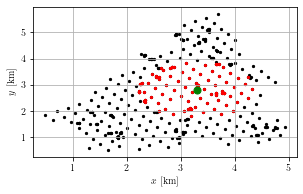

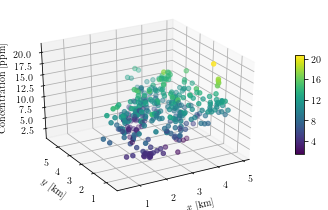

In [8]:
#2D
fig=plt.figure(figsize=(12/2.54,7/2.54))
plt.scatter(data1.iloc[:,0],data1.iloc[:,1],s=5,c='black')
plt.scatter(nearbyPts1.iloc[:,0],nearbyPts1.iloc[:,1],s=5,c='red')
plt.scatter(coordX,coordY,s=50,c='green')
plt.grid()
plt.xlabel('$x$ [km]')
plt.ylabel('$y$ [km]')
plt.show()

#3D
fig=plt.figure(figsize=(12/2.54,7/2.54))
ax=fig.gca(projection='3d')
ax.set_xlabel('$x$ [km]')
ax.set_ylabel('$y$ [km]')
ax.set_zlabel('Concentration [ppm]',rotation=90)
ax.view_init(azim=-120,elev=30)
ax.zaxis.set_rotate_label(False)
points=ax.scatter3D(list(data1.iloc[:,0]),list(data1.iloc[:,1]),list(data1.iloc[:,2]),c=list(data1.iloc[:,2]),cmap='viridis')
fig.colorbar(points, shrink=0.5, aspect=10,format=FormatStrFormatter('%.0f'),ticks=MaxNLocator(5))
plt.tight_layout(pad=0.1)
plt.show()

In [9]:
# C1(si-sj) matrix
C1=np.zeros((nNearPoints1+1, nNearPoints1+1),dtype=float)
np.fill_diagonal(C1, covFunc(0,varFuncMax=varFuncMax1,paramList=popt1))
C1[:-1,nNearPoints1]=1
C1[nNearPoints1,:-1]=1
C1[nNearPoints1,nNearPoints1]=0

for i in range(len(nearbyPts1)):
    for j in range(len(nearbyPts1)):
        if j!=i:
            C1[i,j]=covFunc(((nearbyPts1.iloc[i,0]-nearbyPts1.iloc[j,0])**2+(nearbyPts1.iloc[i,1]-nearbyPts1.iloc[j,1])**2)**0.5,varFuncMax=varFuncMax1,paramList=popt1)
            
display(pd.DataFrame(C1))

# C10(si-s) vector
C10=np.array([covFunc(nearbyPts1.iloc[i,3],varFuncMax=varFuncMax1,paramList=popt1) for i in range(len(nearbyPts1))])
C10=np.append(C10,[[1]])
display(pd.DataFrame(C10))

weightsKrigList=np.linalg.solve(C1,C10)
display(pd.DataFrame(weightsKrigList))

0          1          2          3          4          5    \
0    13.383052   6.996236   6.722483   6.294880   6.256570   6.050525   
1     6.996236  13.383052   8.836458   8.551429   8.427546   8.378789   
2     6.722483   8.836458  13.383052  12.532174  12.435374  12.047180   
3     6.294880   8.551429  12.532174  13.383052  13.187917  12.864086   
4     6.256570   8.427546  12.435374  13.187917  13.383052  12.900527   
..         ...        ...        ...        ...        ...        ...   
96    0.996382   0.568279   0.742905   0.719120   0.725194   0.702758   
97    0.934488   0.588147   0.822186   0.807603   0.816569   0.795847   
98    1.003162   0.564605   0.729228   0.704339   0.709960   0.687470   
99    0.928303   0.585387   0.819290   0.804998   0.813974   0.793416   
100   1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

          6          7         8         9    ...       91         92   \
0    6.996236   5.346182  6.980940  5.343208  ...  0.594183   0.949447   
1    5.346182   6.996236  5.332602  6.980940  ...  1.151648   0.601967   
2    7.287828  10.316042  4.050334  4.635688  ...  0.983295   0.844283   
3    7.050803  10.887186  3.811330  4.462218  ...  1.023775   0.830057   
4    7.103023  11.033774  3.769215  4.397971  ...  1.016822   0.839381   
..        ...        ...       ...       ...  ...       ...        ...   
96   1.379525   0.741696  0.642565  0.389874  ...  0.037692   6.579779   
97   1.495810   0.873356  0.542248  0.362877  ...  0.049654  12.778426   
98   1.353193   0.720880  0.659976  0.394724  ...  0.036232   5.905135   
99   1.489413   0.871346  0.537801  0.360506  ...  0.049590  12.871823   
100  1.000000   1.000000  1.000000  1.000000  ...  1.000000   1.000000   

          93         94        95         96         97         98   \
0    0.594955   1.013984  0.755621   0.996382   0.934488   1.003162   
1    1.012571   0.570059  0.708799   0.568279   0.588147   0.564605   
2    1.201482   0.735222  1.083129   0.742905   0.822186   0.729228   
3    1.283732   0.709960  1.115780   0.719120   0.807603   0.704339   
4    1.290166   0.715584  1.132565   0.725194   0.816569   0.709960   
..        ...        ...       ...        ...        ...        ...   
96   0.105249  11.867881  1.066698  13.383052   6.843865  11.999876   
97   0.167093   6.080445  1.990810   6.843865  13.383052   6.139437   
98   0.097832  13.187917  0.965406  11.999876   6.139437  13.383052   
99   0.167796   6.002958  2.010138   6.757402  13.207032   6.061496   
100  1.000000   1.000000  1.000000   1.000000   1.000000   1.000000   

           99   100  
0     0.928303  1.0  
1     0.585387  1.0  
2     0.819290  1.0  
3     0.804998  1.0  
4     0.813974  1.0  
..         ...  ...  
96    6.757402  1.0  
97   13.207032  1.0  
98    6.061496  1.0  
99   13.383052  1.0  
100   1.000000  0.0  

[101 rows x 101 columns]

0
0    9.757417
1    9.492973
2    8.759099
3    8.219066
4    8.140548
..        ...
96   0.791844
97   0.790509
98   0.790107
99   0.786200
100  1.000000

[101 rows x 1 columns]

0
0    0.414710
1    0.332948
2    0.233012
3   -0.013014
4    0.003273
..        ...
96   0.000172
97   0.000050
98   0.000174
99   0.000213
100 -0.014327

[101 rows x 1 columns]

Sum of weights is 1.000.
Kriged Z value is 12.192.
Average of the Z value of all points is 9.440.
Average of the Z value of the surrounding points is 10.080.


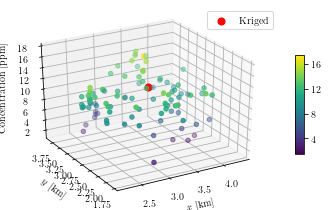

In [10]:
#Sum of weights lambda check
print('Sum of weights is {:.3f}.'. format(weightsKrigList[:-1].sum()))

# Calculating the kriged value
ZKrig=np.dot(np.array(weightsKrigList[:-1]),np.array(nearbyPts1.iloc[:,2]))
print('Kriged Z value is {:.3f}.'.format(ZKrig))

#Mean values
print('Average of the Z value of all points is {:.3f}.'.format(data1.iloc[:,2].mean()))
print('Average of the Z value of the surrounding points is {:.3f}.'.format(nearbyPts1.iloc[:,2].mean()))

#3D plot
fig=plt.figure(figsize=(12/2.54,7/2.54))
ax=fig.gca(projection='3d')
ax.set_xlabel('$x$ [km]')
ax.set_ylabel('$y$ [km]')
ax.set_zlabel('Concentration [ppm]',rotation=90)
ax.view_init(azim=-120,elev=30)
ax.zaxis.set_rotate_label(False)
points=ax.scatter3D(list(nearbyPts1.iloc[:,0]),list(nearbyPts1.iloc[:,1]),list(nearbyPts1.iloc[:,2]),c=list(nearbyPts1.iloc[:,2]),cmap='viridis')
ax.scatter3D(coordX,coordY,ZKrig,c='red',s=50,label='Kriged')
fig.colorbar(points, shrink=0.5, aspect=10,format=FormatStrFormatter('%.0f'),ticks=MaxNLocator(5))
plt.tight_layout(pad=0.1)
plt.legend()
plt.show()

It can be seen from the figure above that the kriged Z value lies between the nearby points. Its value is closer to the Z values of the nearby points that lie closer, since they have greater weight than more distant points, and is not equal to the average of all points nearby what one could assume if kriging wouldn't be performed.

## Ordinary co-kriging

Histograms of all elements are compared at the beginning. Later, from comparisson of the histograms and 3D plots, element with similar shape of the distribution and similar spatial distribution is choosen for the co-kriging.

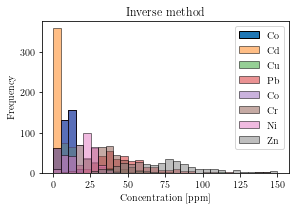

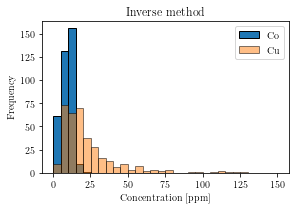

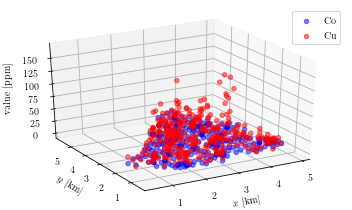

In [11]:
#Plot of all histograms
plt.figure(figsize=(10 /2.54,7/2.54))
plt.hist(data1.iloc[:,2],30,density=False,cumulative=False,range=(dataAll.iloc[:,2:].min().min(),0.5*dataAll.iloc[:,2:].max().max()),edgecolor='black',align='mid',label=data1.columns[2])
for i in range(2,dataAll.shape[1]):
    data2=dataAll.iloc[:,[0,1,i]]
    plt.hist(data2.iloc[:,2],30,density=False,cumulative=False,range=(dataAll.iloc[:,2:].min().min(),0.5*dataAll.iloc[:,2:].max().max()),alpha=0.5,edgecolor='black',align='mid',label=data2.columns[2])
plt.legend()
plt.title('Inverse method')
plt.xlabel('Concentration [ppm]')
plt.ylabel('Frequency')
plt.tight_layout(pad=0.1)
plt.show()

#Plot of histogram of the initially element and the element selected for co-kriging 
plt.figure(figsize=(10 /2.54,7/2.54))
plt.hist(data1.iloc[:,2],30,density=False,cumulative=False,range=(dataAll.iloc[:,2:].min().min(),0.5*dataAll.iloc[:,2:].max().max()),edgecolor='black',align='mid',label=data1.columns[2])

#################### CHOOSEN ELEMENT FOR CO-KRIGING TO BE ENTERED HERE ######################
for i in [3]: #Choose here the desired element, which will be used for co-kriging
#################### CHOOSEN ELEMENT FOR CO-KRIGING TO BE ENTERED HERE ######################

    data2=dataAll.iloc[:,[0,1,i]] 
    plt.hist(data2.iloc[:,2],30,density=False,cumulative=False,range=(dataAll.iloc[:,2:].min().min(),0.5*dataAll.iloc[:,2:].max().max()),alpha=0.5,edgecolor='black',align='mid',label=data2.columns[2])
plt.legend()
plt.title('Inverse method')
plt.xlabel('Concentration [ppm]')
plt.ylabel('Frequency')
plt.tight_layout(pad=0.1)
plt.show()

#3D plot of the data selected for co-kriging
fig=plt.figure(figsize=(12/2.54,7/2.54))
ax=fig.gca(projection='3d')
ax.set_xlabel('$x$ [km]')
ax.set_ylabel('$y$ [km]')
ax.set_zlabel('value [ppm]',rotation=90)
ax.view_init(azim=-120,elev=30)
ax.zaxis.set_rotate_label(False)
ax.scatter3D(list(data1.iloc[:,0]),list(data1.iloc[:,1]),list(data1.iloc[:,2]),c='blue',alpha=0.5,label=data1.columns[2])
ax.scatter3D(list(data2.iloc[:,0]),list(data2.iloc[:,1]),list(data2.iloc[:,2]),c='red',alpha=0.5,label=data2.columns[2])
plt.legend()
plt.tight_layout(pad=0.1)
plt.show()

### Variogram and covariance function for second element

In [12]:
gamma_hList2=[]

for h in range(len(hList)): #hList and hListRange remains the same  
    pairs2=[]
    for i in range(data2.shape[0]):
        for j in range(i+1,data2.shape[0]):
            if ((data2.iloc[j,0]-data2.iloc[i,0])**2+(data2.iloc[j,1]-data2.iloc[i,1])**2)**0.5>=hListRange[h][0]:
                if ((data2.iloc[j,0]-data2.iloc[i,0])**2+(data2.iloc[j,1]-data2.iloc[i,1])**2)**0.5<=hListRange[h][1]:
                    pairs2.append((data2.iloc[i,2],data2.iloc[j,2]))
                  
    gamma_h_2=(1/(2*len(pairs2)))*sum([(x - y)**2 for x, y in pairs2])
    #print(hList[h])
    gamma_hList2.append(gamma_h_2)

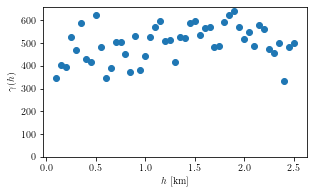

C:\Users\hekic\anaconda3\lib\site-packages\skgstat\Variogram.py:1636: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


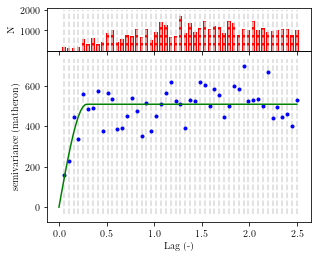

{'name': 'spherical', 'estimator': 'matheron', 'effective_range': 0.2900822574804502, 'sill': 507.289713725438, 'nugget': 0.9899999999999999}


In [13]:
#Scatter plot of (semi)variogram for the second element
fig=plt.figure(figsize=(12/2.54,7/2.54))
plt.scatter(hList,gamma_hList2)
plt.ylim(bottom=0)
plt.xlabel('$h$ [km]')
plt.ylabel('$\gamma(h)$')
plt.show()

#Built-in semi-variogram
V = Variogram(data2.iloc[:,:2], data2.iloc[:,2],n_lags=len(hListRange),maxlag=hList[-1],use_nugget=True)
V.plot()
fig = plt.gcf()
fig.set_figwidth(12/2.54)
fig.set_figheight(10/2.54)
plt.show()
print(V.describe())

Parameters after optimisation are: [381.02058515 146.96263223   1.61575107]


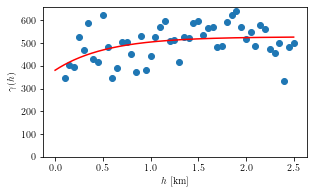

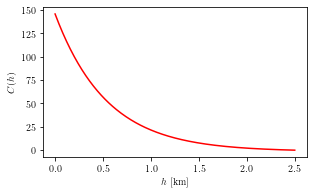

In [14]:
#Determination of empirical variogram function for the second element

#func(h, b1, b2, a2) remains the same

xdata = np.array(hList)
ydata = np.array(gamma_hList2)

#################### TO BE CHANGED IF THE curve_fit GIVES LINEAR FUNCTION ######################
p0_2=[10,-1000,1000] #initial guess (second element)
#################### TO BE CHANGED IF THE curve_fit GIVES LINEAR FUNCTION ######################

popt2, pcov2 = curve_fit(func, xdata, ydata, p0=p0_2, bounds=((0,-np.inf,-np.inf), (np.inf,np.inf,np.inf))) #Use non-linear least squares to fit a function func to data (second element)
print('Parameters after optimisation are: {}'.format(popt2))

#Empiciral variogram function is defined as varFunc

#varFunc(h,paramList) remains the same

#Plot of semivariogram with empirical variogram function
fig=plt.figure(figsize=(12/2.54,7/2.54))
plt.scatter(xdata,ydata)
xdata = np.arange(0,hList[-1]+0.01,0.01) #adding first value '0' and shortening the hDelta interval for nicer plot
plt.plot(xdata, varFunc(xdata, paramList=popt2), 'red')
plt.ylim(bottom=0)
plt.xlabel('$h$ [km]')
plt.ylabel('$\gamma(h)$')
plt.show()

#Determiantion of the covariance function
varFuncMax2=max(varFunc(xdata, paramList=popt2))

#covFunc(h,varFuncMax,paramList) remains the same

fig=plt.figure(figsize=(12/2.54,7/2.54))
xdata = np.arange(0,hList[-1]+0.01,0.01) #adding first value '0' and shortening the hDelta interval for nicer plot
plt.plot(xdata, covFunc(xdata,varFuncMax=varFuncMax2,paramList=popt2), 'red')
plt.xlabel('$h$ [km]')
plt.ylabel('$C(h)$')
plt.show()

### Cross-variogram and cross-covariance function for element 1 and 2

In [15]:
gamma_hList1_2=[]

for h in range(len(hList)): #hList and hListRange remains the same  
    pairs1_2=[]
    for i in range(data1.shape[0]):
        for j in range(i+1,data2.shape[0]):
            if ((data2.iloc[j,0]-data1.iloc[i,0])**2+(data2.iloc[j,1]-data1.iloc[i,1])**2)**0.5>=hListRange[h][0]:
                if ((data2.iloc[j,0]-data1.iloc[i,0])**2+(data2.iloc[j,1]-data1.iloc[i,1])**2)**0.5<=hListRange[h][1]:
                    pairs1_2.append((data1.iloc[i,2],data2.iloc[j,2]))
                    
    gamma_h_1_2=(1/(2*len(pairs1_2)))*sum([(x - y)**2 for x, y in pairs1_2])
    #print(hList[h])
    gamma_hList1_2.append(gamma_h_1_2)

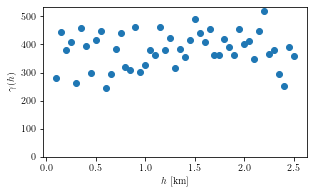

In [16]:
#Scatter plot of cross-(semi)variogram for the first second element
fig=plt.figure(figsize=(12/2.54,7/2.54))
plt.scatter(hList,gamma_hList1_2)
plt.ylim(bottom=0)
plt.xlabel('$h$ [km]')
plt.ylabel('$\gamma(h)$')
plt.show()

#Built-in semi-variogram is not shown here

C:\Users\hekic\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Parameters after optimisation are: [1.60711984e-08 3.82951171e+02 1.54882179e-01]


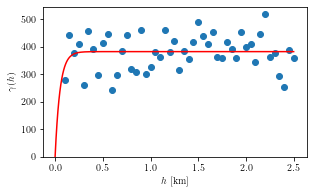

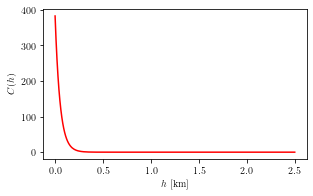

In [17]:
#Determination of empirical cross-variogram function for the first-second element

#func(h, b1, b2, a2) remains the same

xdata = np.array(hList)
ydata = np.array(gamma_hList1_2)

p0_1_2=[5,10,1] #initial guess (first-second element)
popt1_2, pcov1_2 = curve_fit(func, xdata, ydata, p0=p0_1_2, bounds=((0,-np.inf,-np.inf), (np.inf,np.inf,np.inf))) #Use non-linear least squares to fit a function func to data (first-second element)
print('Parameters after optimisation are: {}'.format(popt1_2))

#Empiciral variogram function is defined as varFunc

#varFunc(h,paramList) remains the same

#Plot of semivariogram with empirical variogram function
fig=plt.figure(figsize=(12/2.54,7/2.54))
plt.scatter(xdata,ydata)
xdata = np.arange(0,hList[-1]+0.01,0.01) #adding first value '0' and shortening the hDelta interval for nicer plot
plt.plot(xdata, varFunc(xdata, paramList=popt1_2), 'red')
plt.ylim(bottom=0)
plt.xlabel('$h$ [km]')
plt.ylabel('$\gamma(h)$')
plt.show()

#Determiantion of the cross-covariance function
varFuncMax1_2=max(varFunc(xdata, paramList=popt1_2))

#covFunc(h,varFuncMax,paramList) remains the same

fig=plt.figure(figsize=(12/2.54,7/2.54))
xdata = np.arange(0,hList[-1]+0.01,0.01) #adding first value '0' and shortening the hDelta interval for nicer plot
plt.plot(xdata, covFunc(xdata,varFuncMax=varFuncMax1_2,paramList=popt1_2),'red')
plt.xlabel('$h$ [km]')
plt.ylabel('$C(h)$')
plt.show()

In [18]:
#Selecting the coordinates of the element2 in the nearby of the point, where kriging will be performed
nNearPoints2=100 #10*10 #number of nearby points of element2
#coordX, coordY stays the same

#Determination of the absolute distance between the observing point and points nearby
absDist2=[((x-coordX)**2+(y-coordY)**2)**0.5 for x,y in zip(data2.iloc[:,0],data2.iloc[:,1])] #zip returns an iterator of tuples, where the i-th tuple contains the i-th element from each of the argument sequences or iterables

dataSorted2=pd.concat([data2,pd.DataFrame(absDist2,columns=['distance'])],axis=1).sort_values(by=['distance'])
display(dataSorted2)

nearbyPts2=dataSorted2.iloc[:nNearPoints2,:]
display(nearbyPts2)

x      y     Cu  distance
321  3.212  2.716   29.8  0.121655
229  3.422  2.851     49  0.132231
228  3.308  2.963     28  0.163196
54   3.316  2.987   30.1  0.187683
73   3.312  2.991   22.7  0.191377
..     ...    ...    ...       ...
270  1.646  0.524  18.88  2.813520
106  0.626  1.652    4.2  2.910014
89   3.681   5.69  15.16  2.915006
308  0.491  1.862  21.32  2.961473
181  1.301  0.599   21.2  2.973281

[359 rows x 4 columns]

x      y    Cu  distance
321  3.212  2.716  29.8  0.121655
229  3.422  2.851    49  0.132231
228  3.308  2.963    28  0.163196
54   3.316  2.987  30.1  0.187683
73   3.312  2.991  22.7  0.191377
..     ...    ...   ...       ...
122  2.633   3.65  16.2  1.080458
21   2.219  2.774   8.8  1.081313
112  2.243  3.031  19.2  1.081947
211   2.22  2.732    16  1.082139
174  2.242  3.036    17  1.084002

[100 rows x 4 columns]

### C matrix combining C1, C2, C12, C21; C10_20 matrix combining C10 and C20

In [19]:
# C2(si-sj) matrix - caution: no ones are added at the bottom and at the right side in the C2 matrix
C2=np.zeros((nNearPoints2, nNearPoints2),dtype=float)
np.fill_diagonal(C2,covFunc(0,varFuncMax=varFuncMax2,paramList=popt2))

for i in range(len(nearbyPts2)):
    for j in range(len(nearbyPts2)):
        if j!=i:
            C2[i,j]=covFunc(((nearbyPts2.iloc[i,0]-nearbyPts2.iloc[j,0])**2+(nearbyPts2.iloc[i,1]-nearbyPts2.iloc[j,1])**2)**0.5,varFuncMax=varFuncMax2,paramList=popt2)
print('Matrix C2: ')
display(pd.DataFrame(C2))


# C20(si-s) vector - caution: 1 is not added at the bottom here
C20=np.array([covFunc(nearbyPts2.iloc[i,3],varFuncMax=varFuncMax2,paramList=popt2) for i in range(len(nearbyPts2))])
print('Vector C20: ')
display(pd.DataFrame(C20))


# C12(si-sj') matrix - caution: no ones are added at the bottom and at the right side in the C12 matrix
C12=np.zeros((nNearPoints1, nNearPoints2),dtype=float)

for i in range(len(nearbyPts1)):
    for j in range(len(nearbyPts2)):
            C12[i,j]=covFunc(((nearbyPts2.iloc[i,0]-nearbyPts1.iloc[j,0])**2+(nearbyPts2.iloc[i,1]-nearbyPts1.iloc[j,1])**2)**0.5,varFuncMax=varFuncMax1_2,paramList=popt1_2)
print('Matrix C12: ')
display(pd.DataFrame(C12))


# C21(si-sj') matrix - caution: no ones are added at the bottom and at the right side here
C21=np.zeros((nNearPoints2, nNearPoints1),dtype=float)

for i in range(len(nearbyPts2)):
    for j in range(len(nearbyPts1)):
            C21[i,j]=covFunc(((nearbyPts2.iloc[i,0]-nearbyPts1.iloc[j,0])**2+(nearbyPts2.iloc[i,1]-nearbyPts1.iloc[j,1])**2)**0.5,varFuncMax=varFuncMax1_2,paramList=popt1_2)
print('Matrix C21: ')
display(pd.DataFrame(C21))


#C matrix combining C1, C2, C12, C21
C=np.hstack((C1[:-1,:-1],C12))
C=np.vstack((C,np.hstack((C21,C2))))
C=np.vstack((C,np.zeros((2,nNearPoints1+nNearPoints2))))
C=np.hstack((C,np.zeros((nNearPoints1+nNearPoints2+2,2))))
C[-2,:nNearPoints1]=1
C[-1,nNearPoints1:-2]=1
C[:nNearPoints1,-2]=1
C[nNearPoints1:-2,-1]=1
print('Matrix C: ')
display(pd.DataFrame(C))

#C10_20 vector combining C10 and C20
C10_20=np.hstack((np.hstack((C10[:-1],C20)),[1,0])) #note hstack vs vstack
print('Vector C10_20: ')
display(pd.DataFrame(C10_20))

weightsCokrigList=np.linalg.solve(C,C10_20)
print('Weights for Co-kriging are: ')
display(pd.DataFrame(weightsCokrigList))

Matrix C2: 


0           1           2           3           4           5   \
0   145.545870   91.031415   88.433732   84.315286   83.942512   81.926339   
1    91.031415  145.545870  107.812744  105.283584  104.176911  103.740093   
2    88.433732  107.812744  145.545870  138.802393  138.027133  134.900756   
3    84.315286  105.283584  138.802393  145.545870  144.010369  141.447878   
4    83.942512  104.176911  138.027133  144.010369  145.545870  141.737147   
..         ...         ...         ...         ...         ...         ...   
95   17.685630   16.853068   23.163371   23.682018   23.946995   23.932071   
96   21.763738   14.256739   17.460962   17.037869   17.146271   16.744552   
97   20.744336   14.633710   18.845155   18.593429   18.748348   18.389566   
98   21.874328   14.186631   17.218127   16.772987   16.873884   16.468800   
99   20.641443   14.581560   18.795259   18.548322   18.703553   18.347320   

           6           7          8          9   ...          90         91  \
0   91.031415   74.881319  90.887039  74.851040  ...   22.483418  14.747547   
1   74.881319   91.031415  74.743004  90.887039  ...   14.610010  24.246906   
2   93.766932  120.591515  61.180551  67.502857  ...   17.734864  21.549704   
3   91.545740  125.382717  58.525960  65.654063  ...   17.278637  22.209250   
4   92.036888  126.600817  58.053396  64.964206  ...   17.382591  22.096485   
..        ...         ...        ...        ...  ...         ...        ...   
95  28.947399   27.257883  10.581466  10.154443  ...   21.691285   5.346678   
96  27.728887   17.439559  15.648853  10.686285  ...  135.045604   1.572004   
97  29.442852   19.718880  13.757302  10.110606  ...   83.701914   1.999946   
98  27.335238   17.069307  15.968594  10.788551  ...  141.544857   1.518119   
99  29.349563   19.684842  13.671329  10.059525  ...   82.920172   1.997701   

            92         93          94          95          96          97  \
0    20.992394  14.762085   22.050399   17.685630   21.763738   20.744336   
1    14.893863  22.027441   14.290650   16.853068   14.256739   14.633710   
2    19.224254  25.023690   17.324717   23.163371   17.460962   18.845155   
3    18.980516  26.286396   16.873884   23.682018   17.037869   18.593429   
4    19.140408  26.384200   16.974635   23.946995   17.146271   18.748348   
..         ...        ...         ...         ...         ...         ...   
95   37.625634  18.497064   21.170928  145.545870   22.900735   36.362953   
96   87.067762   3.771990  133.447134   22.900735  145.545870   89.589172   
97  140.767006   5.492739   82.220297   36.362953   89.589172  145.545870   
98   80.491988   3.550972  144.010369   21.255828  134.517845   82.798698   
99  141.509311   5.511283   81.458145   36.622599   88.766734  144.161073   

            98          99  
0    21.874328   20.641443  
1    14.186631   14.581560  
2    17.218127   18.795259  
3    16.772987   18.548322  
4    16.873884   18.703553  
..         ...         ...  
95   21.255828   36.622599  
96  134.517845   88.766734  
97   82.798698  144.161073  
98  145.545870   82.034172  
99   82.034172  145.545870  

[100 rows x 100 columns]

Vector C20: 


0
0   115.832066
1   113.552229
2   107.128628
3   102.304052
4   101.595217
..         ...
95   18.351327
96   18.319976
97   18.296731
98   18.289730
99   18.221673

[100 rows x 1 columns]

Matrix C12: 


0             1             2             3             4   \
0   3.829512e+02  3.041349e+00  2.259116e+00  1.384714e+00  1.323176e+00   
1   3.041349e+00  3.829512e+02  1.732952e+01  1.357215e+01  1.217342e+01   
2   2.259116e+00  1.732952e+01  3.829512e+02  2.346024e+02  2.214183e+02   
3   1.384714e+00  1.357215e+01  2.346024e+02  3.829512e+02  3.432080e+02   
4   1.323176e+00  1.217342e+01  2.214183e+02  3.432080e+02  3.829512e+02   
..           ...           ...           ...           ...           ...   
95  2.182895e-07  1.371315e-07  3.029104e-06  3.766317e-06  4.202402e-06   
96  1.643226e-06  2.771316e-08  1.929440e-07  1.523122e-07  1.619085e-07   
97  1.027879e-06  3.551111e-08  4.036641e-07  3.543079e-07  3.839917e-07   
98  1.726875e-06  2.644691e-08  1.685672e-07  1.309890e-07  1.387702e-07   
99  9.791686e-07  3.432575e-08  3.934138e-07  3.460640e-07  3.751857e-07   

              5         6             7             8             9   ...  \
0   1.031148e+00  3.041349  4.103796e-01  2.992163e+00  4.086838e-01  ...   
1   1.165820e+01  0.410380  3.041349e+00  4.026847e-01  2.992163e+00  ...   
2   1.747751e+02  4.122691  5.495958e+01  5.205488e-02  1.420335e-01  ...   
3   2.851112e+02  3.222567  8.213985e+01  3.312355e-02  1.069536e-01  ...   
4   2.911913e+02  3.404673  9.075479e+01  3.049845e-02  9.601840e-02  ...   
..           ...       ...           ...           ...           ...  ...   
95  4.176677e-06  0.000027  1.511360e-05  1.706269e-09  1.169099e-09  ...   
96  1.288685e-07  0.000018  1.906740e-07  6.733097e-08  1.868329e-09  ...   
97  3.184098e-07  0.000033  6.270355e-07  1.976821e-08  1.123738e-09  ...   
98  1.098572e-07  0.000016  1.550409e-07  8.171753e-08  2.039769e-09  ...   
99  3.113955e-07  0.000032  6.165808e-07  1.863054e-08  1.072863e-09  ...   

              90            91            92            93            94  \
0   2.260576e-06  3.822822e-08  1.154445e-06  3.858844e-08  1.868020e-06   
1   3.496791e-08  4.750672e-06  4.199620e-08  1.849043e-06  2.834508e-08   
2   2.242306e-07  1.491661e-06  4.897836e-07  6.484144e-06  1.789016e-07   
3   1.743657e-07  2.004224e-06  4.326995e-07  1.054901e-05  1.387702e-07   
4   1.847495e-07  1.906647e-06  4.694215e-07  1.094406e-05  1.469549e-07   
..           ...           ...           ...           ...           ...   
95  1.590429e-06  4.320100e-12  3.781587e-04  3.369066e-07  1.254081e-06   
96  1.767222e+02  0.000000e+00  1.925449e+00  2.273737e-13  1.562816e+02   
97  1.284781e+00  0.000000e+00  2.712504e+02  5.400125e-12  1.069726e+00   
98  2.871367e+02  0.000000e+00  8.603386e-01  1.705303e-13  3.432080e+02   
99  1.166883e+00  0.000000e+00  2.863927e+02  5.513812e-12  9.722942e-01   

              95            96            97            98            99  
0   2.182895e-07  1.643226e-06  1.027879e-06  1.726875e-06  9.791686e-07  
1   1.371315e-07  2.771316e-08  3.551111e-08  2.644691e-08  3.432575e-08  
2   3.029104e-06  1.929440e-07  4.036641e-07  1.685672e-07  3.934138e-07  
3   3.766317e-06  1.523122e-07  3.543079e-07  1.309890e-07  3.460640e-07  
4   4.202402e-06  1.619085e-07  3.839917e-07  1.387702e-07  3.751857e-07  
..           ...           ...           ...           ...           ...  
95  3.829512e+02  2.707976e-06  2.683653e-04  1.304136e-06  2.882420e-04  
96  2.707976e-06  3.829512e+02  2.581243e+00  1.697209e+02  2.348003e+00  
97  2.683653e-04  2.581243e+00  3.829512e+02  1.149468e+00  3.469365e+02  
98  1.304136e-06  1.697209e+02  1.149468e+00  3.829512e+02  1.045151e+00  
99  2.882420e-04  2.348003e+00  3.469365e+02  1.045151e+00  3.829512e+02  

[100 rows x 100 columns]

Matrix C21: 


0             1             2             3             4   \
0   3.829512e+02  3.041349e+00  2.259116e+00  1.384714e+00  1.323176e+00   
1   3.041349e+00  3.829512e+02  1.732952e+01  1.357215e+01  1.217342e+01   
2   2.259116e+00  1.732952e+01  3.829512e+02  2.346024e+02  2.214183e+02   
3   1.384714e+00  1.357215e+01  2.346024e+02  3.829512e+02  3.432080e+02   
4   1.323176e+00  1.217342e+01  2.214183e+02  3.432080e+02  3.829512e+02   
..           ...           ...           ...           ...           ...   
95  2.182895e-07  1.371315e-07  3.029104e-06  3.766317e-06  4.202402e-06   
96  1.643226e-06  2.771316e-08  1.929440e-07  1.523122e-07  1.619085e-07   
97  1.027879e-06  3.551111e-08  4.036641e-07  3.543079e-07  3.839917e-07   
98  1.726875e-06  2.644691e-08  1.685672e-07  1.309890e-07  1.387702e-07   
99  9.791686e-07  3.432575e-08  3.934138e-07  3.460640e-07  3.751857e-07   

              5         6             7             8             9   ...  \
0   1.031148e+00  3.041349  4.103796e-01  2.992163e+00  4.086838e-01  ...   
1   1.165820e+01  0.410380  3.041349e+00  4.026847e-01  2.992163e+00  ...   
2   1.747751e+02  4.122691  5.495958e+01  5.205488e-02  1.420335e-01  ...   
3   2.851112e+02  3.222567  8.213985e+01  3.312355e-02  1.069536e-01  ...   
4   2.911913e+02  3.404673  9.075479e+01  3.049845e-02  9.601840e-02  ...   
..           ...       ...           ...           ...           ...  ...   
95  4.176677e-06  0.000027  1.511360e-05  1.706269e-09  1.169099e-09  ...   
96  1.288685e-07  0.000018  1.906740e-07  6.733097e-08  1.868329e-09  ...   
97  3.184098e-07  0.000033  6.270355e-07  1.976821e-08  1.123738e-09  ...   
98  1.098572e-07  0.000016  1.550409e-07  8.171753e-08  2.039769e-09  ...   
99  3.113955e-07  0.000032  6.165808e-07  1.863054e-08  1.072863e-09  ...   

              90            91            92            93            94  \
0   2.260576e-06  3.822822e-08  1.154445e-06  3.858844e-08  1.868020e-06   
1   3.496791e-08  4.750672e-06  4.199620e-08  1.849043e-06  2.834508e-08   
2   2.242306e-07  1.491661e-06  4.897836e-07  6.484144e-06  1.789016e-07   
3   1.743657e-07  2.004224e-06  4.326995e-07  1.054901e-05  1.387702e-07   
4   1.847495e-07  1.906647e-06  4.694215e-07  1.094406e-05  1.469549e-07   
..           ...           ...           ...           ...           ...   
95  1.590429e-06  4.320100e-12  3.781587e-04  3.369066e-07  1.254081e-06   
96  1.767222e+02  0.000000e+00  1.925449e+00  2.273737e-13  1.562816e+02   
97  1.284781e+00  0.000000e+00  2.712504e+02  5.400125e-12  1.069726e+00   
98  2.871367e+02  0.000000e+00  8.603386e-01  1.705303e-13  3.432080e+02   
99  1.166883e+00  0.000000e+00  2.863927e+02  5.513812e-12  9.722942e-01   

              95            96            97            98            99  
0   2.182895e-07  1.643226e-06  1.027879e-06  1.726875e-06  9.791686e-07  
1   1.371315e-07  2.771316e-08  3.551111e-08  2.644691e-08  3.432575e-08  
2   3.029104e-06  1.929440e-07  4.036641e-07  1.685672e-07  3.934138e-07  
3   3.766317e-06  1.523122e-07  3.543079e-07  1.309890e-07  3.460640e-07  
4   4.202402e-06  1.619085e-07  3.839917e-07  1.387702e-07  3.751857e-07  
..           ...           ...           ...           ...           ...  
95  3.829512e+02  2.707976e-06  2.683653e-04  1.304136e-06  2.882420e-04  
96  2.707976e-06  3.829512e+02  2.581243e+00  1.697209e+02  2.348003e+00  
97  2.683653e-04  2.581243e+00  3.829512e+02  1.149468e+00  3.469365e+02  
98  1.304136e-06  1.697209e+02  1.149468e+00  3.829512e+02  1.045151e+00  
99  2.882420e-04  2.348003e+00  3.469365e+02  1.045151e+00  3.829512e+02  

[100 rows x 100 columns]

Matrix C: 


0             1             2             3             4    \
0    1.338305e+01  6.996236e+00  6.722483e+00  6.294880e+00  6.256570e+00   
1    6.996236e+00  1.338305e+01  8.836458e+00  8.551429e+00  8.427546e+00   
2    6.722483e+00  8.836458e+00  1.338305e+01  1.253217e+01  1.243537e+01   
3    6.294880e+00  8.551429e+00  1.253217e+01  1.338305e+01  1.318792e+01   
4    6.256570e+00  8.427546e+00  1.243537e+01  1.318792e+01  1.338305e+01   
..            ...           ...           ...           ...           ...   
197  1.027879e-06  3.551111e-08  4.036641e-07  3.543079e-07  3.839917e-07   
198  1.726875e-06  2.644691e-08  1.685672e-07  1.309890e-07  1.387702e-07   
199  9.791686e-07  3.432575e-08  3.934138e-07  3.460640e-07  3.751857e-07   
200  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
201  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              5         6             7             8             9    ...  \
0    6.050525e+00  6.996236  5.346182e+00  6.980940e+00  5.343208e+00  ...   
1    8.378789e+00  5.346182  6.996236e+00  5.332602e+00  6.980940e+00  ...   
2    1.204718e+01  7.287828  1.031604e+01  4.050334e+00  4.635688e+00  ...   
3    1.286409e+01  7.050803  1.088719e+01  3.811330e+00  4.462218e+00  ...   
4    1.290053e+01  7.103023  1.103377e+01  3.769215e+00  4.397971e+00  ...   
..            ...       ...           ...           ...           ...  ...   
197  3.184098e-07  0.000033  6.270355e-07  1.976821e-08  1.123738e-09  ...   
198  1.098572e-07  0.000016  1.550409e-07  8.171753e-08  2.039769e-09  ...   
199  3.113955e-07  0.000032  6.165808e-07  1.863054e-08  1.072863e-09  ...   
200  1.000000e+00  1.000000  1.000000e+00  1.000000e+00  1.000000e+00  ...   
201  0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  ...   

              192           193           194           195           196  \
0    1.154445e-06  3.858844e-08  1.868020e-06  2.182895e-07  1.643226e-06   
1    4.199620e-08  1.849043e-06  2.834508e-08  1.371315e-07  2.771316e-08   
2    4.897836e-07  6.484144e-06  1.789016e-07  3.029104e-06  1.929440e-07   
3    4.326995e-07  1.054901e-05  1.387702e-07  3.766317e-06  1.523122e-07   
4    4.694215e-07  1.094406e-05  1.469549e-07  4.202402e-06  1.619085e-07   
..            ...           ...           ...           ...           ...   
197  1.407670e+02  5.492739e+00  8.222030e+01  3.636295e+01  8.958917e+01   
198  8.049199e+01  3.550972e+00  1.440104e+02  2.125583e+01  1.345178e+02   
199  1.415093e+02  5.511283e+00  8.145814e+01  3.662260e+01  8.876673e+01   
200  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
201  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

              197           198           199  200  201  
0    1.027879e-06  1.726875e-06  9.791686e-07  1.0  0.0  
1    3.551111e-08  2.644691e-08  3.432575e-08  1.0  0.0  
2    4.036641e-07  1.685672e-07  3.934138e-07  1.0  0.0  
3    3.543079e-07  1.309890e-07  3.460640e-07  1.0  0.0  
4    3.839917e-07  1.387702e-07  3.751857e-07  1.0  0.0  
..            ...           ...           ...  ...  ...  
197  1.455459e+02  8.279870e+01  1.441611e+02  0.0  1.0  
198  8.279870e+01  1.455459e+02  8.203417e+01  0.0  1.0  
199  1.441611e+02  8.203417e+01  1.455459e+02  0.0  1.0  
200  0.000000e+00  0.000000e+00  0.000000e+00  0.0  0.0  
201  1.000000e+00  1.000000e+00  1.000000e+00  0.0  0.0  

[202 rows x 202 columns]

Vector C10_20: 


0
0     9.757417
1     9.492973
2     8.759099
3     8.219066
4     8.140548
..         ...
197  18.296731
198  18.289730
199  18.221673
200   1.000000
201   0.000000

[202 rows x 1 columns]

Weights for Co-kriging are: 


0
0     0.218369
1     0.212235
2     0.124790
3     0.020057
4     0.015881
..         ...
197   0.004503
198   0.002310
199   0.002375
200  -0.947876
201  36.421490

[202 rows x 1 columns]

Sum of weights for co-kriging is 1.000.
Kriged Z value is 12.192.
Average of the Z value of all points (element 1) is 9.440.
Average of the Z value of the surrounding points (element 1) is 10.080.
Co-kriged Z value is 12.316.
Average of the Z value of all points (element 2) is 23.585.
Average of the Z value of the surrounding points (element 2) is 22.250.


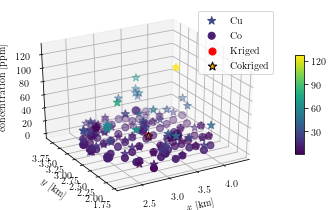

In [20]:
#Sum of weights lambda check
print('Sum of weights for co-kriging is {:.3f}.'. format(weightsCokrigList[:-2].sum()))

#Kriged value (from previous task)
print('Kriged Z value is {:.3f}.'.format(ZKrig))

#Mean values
print('Average of the Z value of all points (element 1) is {:.3f}.'.format(data1.iloc[:,2].mean()))
print('Average of the Z value of the surrounding points (element 1) is {:.3f}.'.format(nearbyPts1.iloc[:,2].mean()))

# Calculating the co-kriged value
ZCokrig=np.dot(np.array(weightsCokrigList[:nNearPoints1]),np.array(nearbyPts1.iloc[:,2]))+np.dot(np.array(weightsCokrigList[nNearPoints1:-2]),np.array(nearbyPts2.iloc[:,2]))
print('Co-kriged Z value is {:.3f}.'.format(ZCokrig))

#Mean values
print('Average of the Z value of all points (element 2) is {:.3f}.'.format(data2.iloc[:,2].mean()))
print('Average of the Z value of the surrounding points (element 2) is {:.3f}.'.format(nearbyPts2.iloc[:,2].mean()))

#3D plot
fig=plt.figure(figsize=(12/2.54,7/2.54))
ax=fig.gca(projection='3d')
ax.set_xlabel('$x$ [km]')
ax.set_ylabel('$y$ [km]')
ax.set_zlabel('concentration [ppm]',rotation=90)
ax.view_init(azim=-120,elev=30)
ax.zaxis.set_rotate_label(False)

mini=min(min(nearbyPts1.iloc[:,2]),min(nearbyPts2.iloc[:,2])) #this is necessary for colorbar plot
maxi=max(max(nearbyPts1.iloc[:,2]),max(nearbyPts2.iloc[:,2])) #this is necessary for colorbar plot
norm = plt.Normalize(mini,maxi) #this is necessary for colorbar plot

points=ax.scatter3D(list(nearbyPts2.iloc[:,0]),list(nearbyPts2.iloc[:,1]),list(nearbyPts2.iloc[:,2]),c=list(nearbyPts2.iloc[:,2]),cmap='viridis',marker='*',label=data2.columns[2],s=70,norm=norm)
points=ax.scatter3D(list(nearbyPts1.iloc[:,0]),list(nearbyPts1.iloc[:,1]),list(nearbyPts1.iloc[:,2]),c=list(nearbyPts1.iloc[:,2]),cmap='viridis',label=data1.columns[2],s=50,norm=norm)
ax.scatter3D(coordX,coordY,ZKrig,c='red',s=50,label='Kriged')
ax.scatter3D(coordX,coordY,ZCokrig,c='orange',edgecolor='black',marker='*',s=80,label='Cokriged')
fig.colorbar(points, shrink=0.5, aspect=10,format=FormatStrFormatter('%.0f'),ticks=MaxNLocator(5))
plt.legend()
plt.tight_layout(pad=0.1)
plt.show()

It can be seen from the values calculated and the figure above that the co-kriged Z value differs from the kriged value and all averages obtained. This is due to the correlation between the 1st and the 2nd elements considered; at co-kriging not only the distribution of the 1st, but also the distribution of the 2nd element is taken into account to predict the Z value of the 1st element.

## Kriging on the area

Area, where kriging will be performed is represented by green scatters. Red scatters represents all nearby measurement points that were considered for kriging (10 nearby points for each kriging point).

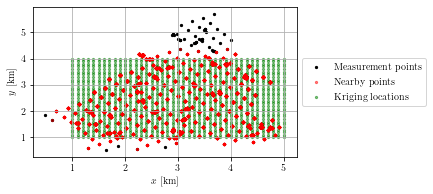

In [21]:
#Selecting the coordinates for the point, where kriging will be performed

#################### HERE ENTER THE LIST OF COORDINATES FOR POINT WHERE KRIGING WILL BE PERFORMED AND NUMBER OF THE NEARBY POINTS ######################
nNearPoints1=10 #number of nearby points around one point to be kriged
coordXList=np.arange(1,5+0.1,0.1)
coordYList=np.arange(1,4+0.1,0.1)
#################### HERE ENTER THE LIST OF COORDINATES FOR POINT WHERE KRIGING WILL BE PERFORMED AND NUMBER OF THE NEARBY POINTS ######################

#Plot of measurement points, nearby points and points for which kriging will be performed
fig=plt.figure(figsize=(12/2.54,7/2.54))
labels = {"1st" : "Measurement points", "2nd" : "Nearby points", "3rd" : "Kriging locations"} #tis should be defined as a dictionary to avoid confusion of labels in loop
plt.scatter(data1.iloc[:,0],data1.iloc[:,1],s=5,marker='o',c='black',alpha=1,label=labels["1st"])
labels["1st"] = "_nolegend_"
plt.grid()
for coordX in coordXList:
    for coordY in coordYList:
        #Determination of the absolute distance between the observing point and points nearby
        absDist1=[((x-coordX)**2+(y-coordY)**2)**0.5 for x,y in zip(data1.iloc[:,0],data1.iloc[:,1])] 
        dataSorted1=pd.concat([data1,pd.DataFrame(absDist1,columns=['distance'])],axis=1).sort_values(by=['distance'])
        nearbyPts1=dataSorted1.iloc[:nNearPoints1,:]
        #2D plot of all points and points, for which kriging will be performed
        plt.scatter(nearbyPts1.iloc[:,0],nearbyPts1.iloc[:,1],s=5,c="red",alpha=0.5,label=labels["2nd"])
        labels["2nd"] = "_nolegend_"
        plt.scatter(coordX,coordY,s=5,c='green',alpha=0.5,label=labels["3rd"])
        labels["3rd"] = "_nolegend_"
plt.xlabel('$x$ [km]')
plt.ylabel('$y$ [km]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The procedure for kriging from the beginning of this task is repeated here for all points in 'coordXList' and 'coordYList'.

In [22]:
coordXArea, coordYArea = np.meshgrid(coordXList,coordYList)
ZKrigArea=np.zeros((len(coordYList),len(coordXList)))

for i in range(len(coordXList)):
    coordX=coordXList[i]
    for j in range(len(coordYList)):
        coordY=coordXList[j]
        #Determination of the absolute distance between the observing point and points nearby
        absDist1=[((x-coordX)**2+(y-coordY)**2)**0.5 for x,y in zip(data1.iloc[:,0],data1.iloc[:,1])] 
        dataSorted1=pd.concat([data1,pd.DataFrame(absDist1,columns=['distance'])],axis=1).sort_values(by=['distance'])
        nearbyPts1=dataSorted1.iloc[:nNearPoints1,:]
        
        # C1(si-sj) matrix
        C1=np.zeros((nNearPoints1+1, nNearPoints1+1),dtype=float)
        np.fill_diagonal(C1, covFunc(0,varFuncMax=varFuncMax1,paramList=popt1))
        C1[:-1,nNearPoints1]=1
        C1[nNearPoints1,:-1]=1
        C1[nNearPoints1,nNearPoints1]=0

        for k in range(len(nearbyPts1)):
            for l in range(len(nearbyPts1)):
                if l!=k:
                    C1[k,l]=covFunc(((nearbyPts1.iloc[k,0]-nearbyPts1.iloc[l,0])**2+(nearbyPts1.iloc[k,1]-nearbyPts1.iloc[l,1])**2)**0.5,varFuncMax=varFuncMax1,paramList=popt1)
            
        # C10(si-s) vector
        C10=np.array([covFunc(nearbyPts1.iloc[l,3],varFuncMax=varFuncMax1,paramList=popt1) for l in range(len(nearbyPts1))])
        C10=np.append(C10,[[1]])
        
        #Solving system of linear equations
        weightsKrigArea_=np.linalg.solve(C1,C10)

        #Sum of weights lambda check
        if abs(weightsKrigArea_[:-1].sum()-1) > 0.000001:
            print('Sum of weights is {:.3f}.'. format(weightsKrigArea_[:-1].sum()))

        # Calculating the kriged value
        ZKrigArea_=np.dot(np.array(weightsKrigArea_[:-1]),np.array(nearbyPts1.iloc[:,2]))
        #print(ZKrigArea_)
        
        ZKrigArea[j,i]=ZKrigArea_

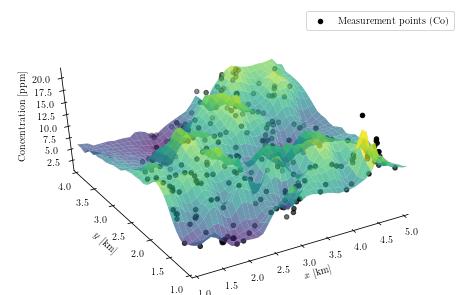

In [24]:
#3D plot
fig=plt.figure(figsize=(16/2.54,10/2.54))
ax=fig.gca(projection='3d')
ax.set_xlabel('$x$ [km]')
ax.set_ylabel('$y$ [km]')
ax.set_zlabel('Concentration [ppm]',rotation=90)
ax.view_init(azim=-120,elev=50)
ax.zaxis.set_rotate_label(False)

scatterXTemp=np.ma.masked_outside(data1.iloc[:,0],min(coordXList),max(coordXList)) #this is to mask the 3D scatters outside kriging area (to avoid bugg in python)
scatterYTemp=np.ma.masked_outside(data1.iloc[:,1],min(coordYList),max(coordYList)) #this is to mask the 3D scatters outside kriging area (to avoid bugg in python)

ax.scatter3D(scatterXTemp,scatterYTemp,list(data1.iloc[:,2]),c='black',label="Measurement points ("+str(data1.columns[2])+")") #if not masking 3D scatters out of the region
#ax.scatter3D(list(data1.iloc[:,0]),list(data1.iloc[:,1]),list(data1.iloc[:,2]),c='black',label="Measurement points ("+str(data1.columns[2])+")") #if not masking 3D scatters out of the region
ax.plot_surface(coordXArea, coordYArea, ZKrigArea, cmap='viridis', edgecolor='none',alpha=0.7)
ax.w_xaxis.set_pane_color ((0., 0., 0., 0.)) #transparent background
ax.w_yaxis.set_pane_color ((0., 0., 0., 0.)) #transparent background
ax.w_zaxis.set_pane_color ((0., 0., 0., 0.)) #transparent background
ax.grid(b=None)
ax.set_xlim(min(coordXList),max(coordXList))
ax.set_ylim(min(coordYList),max(coordYList))
plt.legend()
plt.tight_layout(pad=0.1)
plt.show()